In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.pyplot import rc_context
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.logging.print_header()

2023-06-11 12:39:22.746043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
2023-06-11 12:39:22.746117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.1 scipy==1.8.1 pandas==1.3.1 scikit-learn==0.24.2 statsmodels==0.13.2 python-igraph==0.9.6 pynndescent==0.5.4


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Load prenatal skin dataset data object

In [5]:
#load data object: prenatal skin only, post qc

fskin_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fskin_path = root_path + fskin_object
adata = sc.read(fskin_path)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [6]:
print(list(adata.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neuron pr

# Comparison of WNT2+ fibroblasts early vs late determined from Milo analysis

## Create milo object

In [7]:
#load csv (from R Milo output) - contains additional metadata column of 'Enrichment' early or late
milo_all = pd.read_csv('/home/jovyan/mount_farm/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/out_files/milo_res_index_cells.csv')
milo_all

,Unnamed: 0,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ
0,0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.467129,8.509011,3.681059,5.796283e-02,8.471681e-02,LYVE1++ macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK
1,1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.225872,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte precursor,0.940000,0.225872,Monocyte precursor,SK
2,2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.545171,8.029361,3.813226,5.375057e-02,7.919520e-02,NK cell,0.833333,0.545171,NK cell,SK
3,3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.455915,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.650000,0.455915,Monocyte,SK
4,4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.499632,8.008494,5.639032,1.952530e-02,3.178586e-02,MHCII+ macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.909980,7.625171,12.977361,4.969357e-04,1.173709e-03,LE,1.000000,0.909980,LE,SK
13669,13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.961300,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid (fetal),1.000000,0.961300,Erythroid (fetal),SK
13670,13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,1.556564,7.540454,44.229991,5.568452e-09,9.926531e-08,DPYSL2+ basal,0.961538,1.556564,DPYSL2+ basal,SK
13671,13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.939307,7.671832,10.378170,1.730997e-03,3.588224e-03,Pericytes,0.988235,0.939307,Pericytes,SK


In [8]:
milo_all.drop(columns=['Unnamed: 0'], inplace=True)
milo_all.rename(columns={'index_cell': 'index'}, inplace=True)
milo_all.set_index('index', inplace=True)
milo_all

,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ
index,,,,,,,,,,,,
ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.467129,8.509011,3.681059,5.796283e-02,8.471681e-02,LYVE1++ macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK
ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.225872,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte precursor,0.940000,0.225872,Monocyte precursor,SK
ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.545171,8.029361,3.813226,5.375057e-02,7.919520e-02,NK cell,0.833333,0.545171,NK cell,SK
ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.455915,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.650000,0.455915,Monocyte,SK
ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.499632,8.008494,5.639032,1.952530e-02,3.178586e-02,MHCII+ macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.909980,7.625171,12.977361,4.969357e-04,1.173709e-03,LE,1.000000,0.909980,LE,SK
TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.961300,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid (fetal),1.000000,0.961300,Erythroid (fetal),SK
TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,1.556564,7.540454,44.229991,5.568452e-09,9.926531e-08,DPYSL2+ basal,0.961538,1.556564,DPYSL2+ basal,SK


In [9]:
len(list(milo_all.index))

13673

In [10]:
adata_milo = adata[adata.obs.index.isin(list(milo_all.index))]
adata_milo

View of AnnData object with n_obs × n_vars = 13673 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220

In [11]:
adata_milo.obs = pd.merge(adata_milo.obs, milo_all, left_index=True, right_index=True)
adata_milo.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ
index,,,,,,,,,,,,,,,,,,,,,
ACCCACTAGGCAGTCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,-0.467129,8.509011,3.681059,5.796283e-02,8.471681e-02,LYVE1++ macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK
ACGCCAGAGCAGGTCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,0.225872,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte precursor,0.940000,0.225872,Monocyte precursor,SK
ACGCCAGCACCACCAG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.254438,...,0.545171,8.029361,3.813226,5.375057e-02,7.919520e-02,NK cell,0.833333,0.545171,NK cell,SK
ATAACGCGTAGAGCTG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,0.455915,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.650000,0.455915,Monocyte,SK
ATAGACCTCTGCGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,-0.499632,8.008494,5.639032,1.952530e-02,3.178586e-02,MHCII+ macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCTGCAGTA-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.083573,...,0.909980,7.625171,12.977361,4.969357e-04,1.173709e-03,LE,1.000000,0.909980,LE,SK
TTTCCTCTCATAAAGG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.021002,...,0.961300,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid (fetal),1.000000,0.961300,Erythroid (fetal),SK
TTTGCGCAGCCTTGAT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.099042,...,1.556564,7.540454,44.229991,5.568452e-09,9.926531e-08,DPYSL2+ basal,0.961538,1.556564,DPYSL2+ basal,SK


In [12]:
adata_milo

AnnData object with n_obs × n_vars = 13673 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'k

In [13]:
adata_milo.obs['Enrichment'] = 'Mixed'
adata_milo.obs.loc[(adata_milo.obs['SpatialFDR'] < 0.05) & (adata_milo.obs['logFC'] < 0), ['Enrichment']] = 'Early'
adata_milo.obs.loc[(adata_milo.obs['SpatialFDR'] < 0.05) & (adata_milo.obs['logFC'] > 0), ['Enrichment']] = 'Late'
list(adata_milo.obs['Enrichment'].unique())

['Mixed', 'Early', 'Late']

In [14]:
#list(adata_milo.obs['Enrichment'].unique())

In [15]:
adata_milo.obs['Enrichment'].value_counts()

Late     5424
Mixed    4822
Early    3427
Name: Enrichment, dtype: int64

In [16]:
adata_milo.obs['early_late_pcw'] = adata_milo.obs['Enrichment'].astype(str) + '_' + adata_milo.obs['pcw'].astype(str)

In [17]:
adata_milo.obs['early_late_celltype'] = adata_milo.obs['Enrichment'].astype(str) + '_' + adata_milo.obs['joint_annotation_20220202'].astype(str)

In [18]:
adata_milo.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ,Enrichment,early_late_pcw,early_late_celltype
index,,,,,,,,,,,,,,,,,,,,,
ACCCACTAGGCAGTCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,5.796283e-02,8.471681e-02,LYVE1++ macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK,Mixed,Mixed_8,Mixed_LYVE1++ macrophage
ACGCCAGAGCAGGTCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,5.151409e-01,5.808132e-01,Monocyte precursor,0.940000,0.225872,Monocyte precursor,SK,Mixed,Mixed_8,Mixed_Monocyte precursor
ACGCCAGCACCACCAG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.254438,...,5.375057e-02,7.919520e-02,NK cell,0.833333,0.545171,NK cell,SK,Mixed,Mixed_8,Mixed_NK cell
ATAACGCGTAGAGCTG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,5.141347e-01,5.798700e-01,Monocyte,0.650000,0.455915,Monocyte,SK,Mixed,Mixed_8,Mixed_Monocyte
ATAGACCTCTGCGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,1.952530e-02,3.178586e-02,MHCII+ macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK,Early,Early_8,Early_Monocyte (activated/differentiating)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCTGCAGTA-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.083573,...,4.969357e-04,1.173709e-03,LE,1.000000,0.909980,LE,SK,Late,Late_14,Late_LE
TTTCCTCTCATAAAGG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.021002,...,2.934164e-05,9.470923e-05,Erythroid (fetal),1.000000,0.961300,Erythroid (fetal),SK,Late,Late_14,Late_Erythroid (fetal)
TTTGCGCAGCCTTGAT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.099042,...,5.568452e-09,9.926531e-08,DPYSL2+ basal,0.961538,1.556564,DPYSL2+ basal,SK,Late,Late_14,Late_DPYSL2+ basal


In [28]:
#adata_milo.write_h5ad(root_path +'milo_enrichment.h5ad')

## Subset to early and late WNT2+ fibroblasts

In [29]:
# load adata_milo created above

In [19]:
adata_milo

AnnData object with n_obs × n_vars = 13673 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'k

In [20]:
print(list(adata_milo.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte precursor', 'NK cell', 'Monocyte', 'Monocyte (activated/differentiating)', 'Iron-recycling macrophage', 'Megakaryocyte', 'HSC', 'WNT2+ fibroblast', 'Pre-dermal condensate', 'Myofibroblasts', 'Pericytes', 'Myoblasts', 'DC1', 'Erythroid (fetal)', 'MHCII+ macrophage', 'ILC3', 'PEAR1+ fibroblast', 'Schwann/Schwann precursors', 'Postcapillary venules', 'DC2', 'Innate T type1', 'TREM2+ macrophage', 'SPP1+ proliferating neuron progenitors', 'LTi', 'Neutrophil2', 'LC', 'Pre pro B cell', 'CD8 T cell', 'ILC2', 'Mast cell (medium)', 'LMCD1+ mural cell', 'Melanoblast', 'Neuron progenitors', 'HOXC5+ early fibroblast', 'Neuroendocrine', 'Myelinating Schwann cells', 'Periderm', 'Mast cell (earliest)', 'Capillaries', 'Lymphoid progenitor', 'MEMP - Early erythroid', 'Immature basal', 'Innate T type3', 'Pro B cell', 'Early myocytes', 'PID1+ schwann cellls', 'MEMP - Megak', 'B cell', 'Pre B cell', 'pDC', 'Treg', 'CD4 T cell', 'Mast cell (most mature)', 'Eo/baso/mast cell 

In [21]:
print(list(adata_milo.obs['Enrichment'].unique()))

['Mixed', 'Early', 'Late']


In [22]:
cells_keepfib = ['WNT2+ fibroblast']
adata_milo_WNT2fib = adata_milo[adata_milo.obs['joint_annotation_20220202'].isin(cells_keepfib)]

In [23]:
enrichment_keep = ['Late','Early']
adata_milo_WNT2fib = adata_milo_WNT2fib[adata_milo_WNT2fib.obs['Enrichment'].isin(enrichment_keep)]
adata_milo_WNT2fib

View of AnnData object with n_obs × n_vars = 1233 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_202202

In [31]:
#only keep genes present in about >10% cells (see method in Suo, Dann et al)
#sc.pp.filter_genes(adata_milo_WNT2fib, min_cells=120)

filtered out 22273 genes that are detected in less than 120 cells


Trying to set attribute `.var` of view, copying.


In [24]:
#compute DEGs between early and late WNT2+ fibroblast
sc.pp.highly_variable_genes(adata_milo_WNT2fib)

extracting highly variable genes
    finished (0:00:00)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [25]:
adata_milo_WNT2fib

AnnData object with n_obs × n_vars = 1233 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'kt

In [26]:
sc.tl.rank_genes_groups(adata_milo_WNT2fib, groupby='Enrichment', key_added='rank_genes_groups_MiloFib', method = 'wilcoxon')

ranking genes


/home/jovyan/my-conda-envs/my_new_env_clone2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'nhood_annotation' as categorical
/home/jovyan/my-conda-envs/my_new_env_clone2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'nhood_anno' as categorical
/home/jovyan/my-conda-envs/my_new_env_clone2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reo

    finished: added to `.uns['rank_genes_groups_MiloFib']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


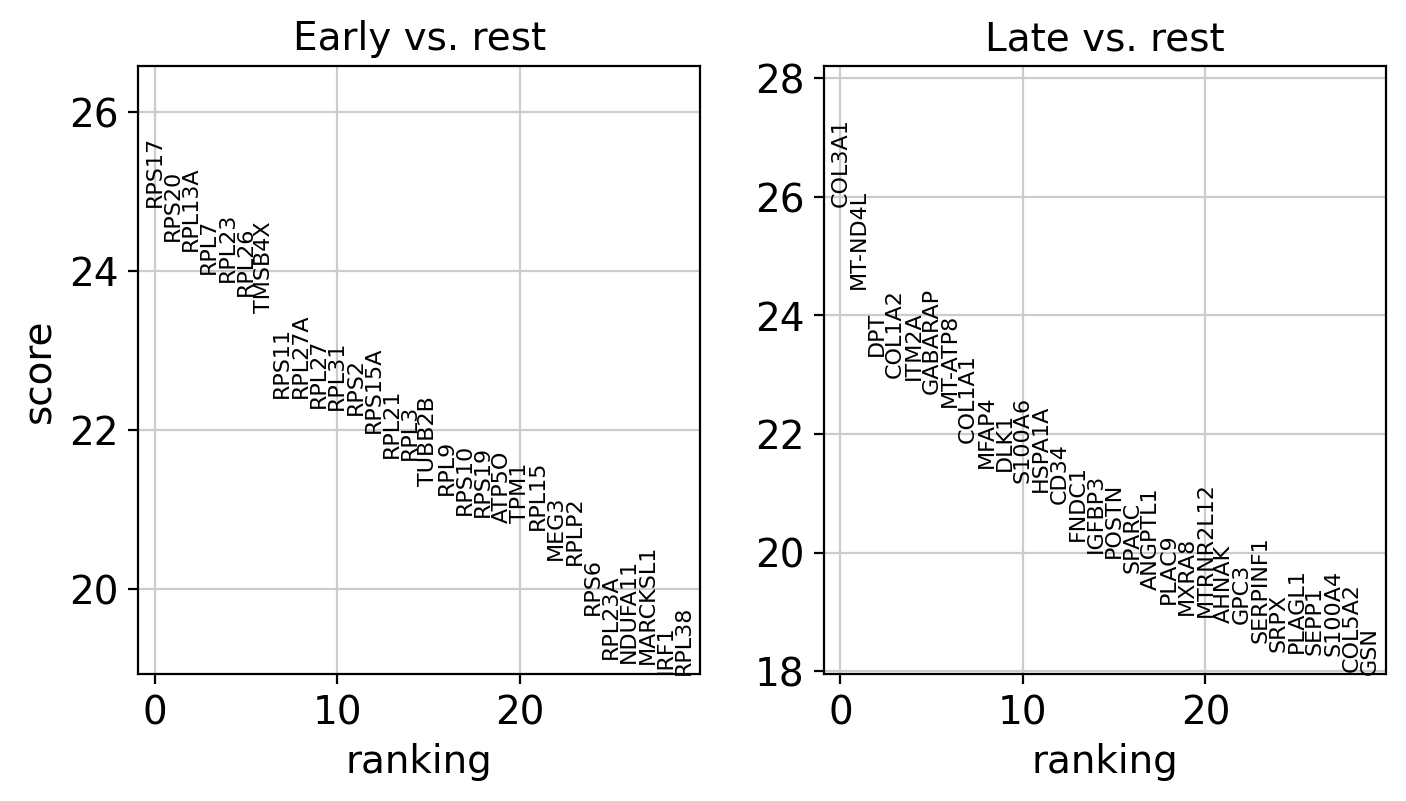

In [27]:
sc.pl.rank_genes_groups(adata_milo_WNT2fib, n_genes=30, sharey=False, key='rank_genes_groups_MiloFib')

In [28]:
#get list of significant genes for early and late WNT2+ fibroblast to be used in GSEApy analysis
genes_WNT2fib_Early = sc.get.rank_genes_groups_df(adata_milo_WNT2fib, group='Early', key='rank_genes_groups_MiloFib', log2fc_min=1.00, 
                                    pval_cutoff=0.01)[['names', 'pvals', 'logfoldchanges', 'scores']]

genes_WNT2fib_Late = sc.get.rank_genes_groups_df(adata_milo_WNT2fib, group='Late', key='rank_genes_groups_MiloFib', log2fc_min=1.00, 
                                    pval_cutoff=0.01)[['names', 'pvals', 'logfoldchanges', 'scores']]

In [29]:
#save genes list as csv
genes_WNT2fib_Early.to_csv('/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_early_logfc1p001_11062023.csv')
genes_WNT2fib_Late.to_csv('/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_late_logfc1p001_11062023.csv')

In [30]:
glist_WNT2fib_Early = genes_WNT2fib_Early['names'].squeeze().str.strip().tolist()
print(len(glist_WNT2fib_Early))

582


In [31]:
glist_WNT2fib_Late = genes_WNT2fib_Late['names'].squeeze().str.strip().tolist()
print(len(glist_WNT2fib_Late))

341


## GSEApy analysis

In [32]:
import gseapy as gp

In [33]:
from gseapy.plot import barplot, dotplot

In [34]:
enr_WNT2fibearly = gp.enrichr(gene_list=glist_WNT2fib_Early,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human',
                 #description='gseaWNT2fibearly',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_early',
                 no_plot=True,
                 cutoff=0.05)

In [35]:
enr_WNT2fibearly_Hallmark = gp.enrichr(gene_list=glist_WNT2fib_Early,
                 gene_sets='MSigDB_Hallmark_2020',
                 organism='Human',
                 #description='gseaWNT2fibearly',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_early',
                 no_plot=True,
                 cutoff=0.05)

In [36]:
enr_WNT2fiblate = gp.enrichr(gene_list=glist_WNT2fib_Late,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human',
                 #description='gseaWNT2fiblate',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_late',
                 no_plot=True,
                 cutoff=0.05)

In [37]:
enr_WNT2fiblate_Hallmark = gp.enrichr(gene_list=glist_WNT2fib_Late,
                 gene_sets='MSigDB_Hallmark_2020',
                 organism='Human',
                 #description='gseaWNT2fiblate',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_late',
                 no_plot=True,
                 cutoff=0.05)

In [38]:
enr_WNT2fibearly.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),18/93,1.654067e-10,3.258722e-07,0,0,8.231064,185.385072,EIF4A1;RPL21;RPL31;RPL23;RPL36A;RPL13A;RPL7;RP...
1,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,18/94,1.991275e-10,3.258722e-07,0,0,8.122340,181.429333,SRP19;ARL6IP1;RPL21;RPL31;RPL23;RPL36A;RPL13A;...
2,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",74/1183,3.741359e-10,4.081823e-07,0,0,2.404923,52.202215,CSRNP1;PRDM2;ELK3;IRF2BPL;PPP3CA;ING2;MYC;HYAL...
3,GO_Biological_Process_2021,cellular protein metabolic process (GO:0044267),38/417,5.569035e-10,4.195405e-07,0,0,3.509051,74.773056,RPL31;TNC;RPL36A;PLOD2;NEDD8;PLAT;PRSS23;LTBP1...
4,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",19/113,6.448220e-10,4.195405e-07,0,0,6.937682,146.815548,RPL21;RPL31;RPL23;RPL36A;RPL13A;RPL7;HELZ2;PPP...
5,GO_Biological_Process_2021,SRP-dependent cotranslational protein targetin...,17/90,7.950635e-10,4.195405e-07,0,0,7.973451,167.064530,SRP19;RPL21;RPL31;RPL23;RPL36A;RPL13A;RPL7;RPS...
6,GO_Biological_Process_2021,protein targeting to ER (GO:0045047),18/103,9.517853e-10,4.195405e-07,0,0,7.258949,150.787830,SRP19;RPL21;RPL31;RPL23;RPL36A;RPL13A;RPL7;RPS...
7,GO_Biological_Process_2021,nuclear-transcribed mRNA catabolic process (GO...,23/171,1.025458e-09,4.195405e-07,0,0,5.357177,110.883536,DDX5;RPL21;RPL31;RPL23;RPL36A;SAMD4A;RPL13A;SA...
8,GO_Biological_Process_2021,regulation of cell population proliferation (G...,54/764,1.731646e-09,6.297421e-07,0,0,2.694814,54.365705,BTG2;CDKN1A;TES;CXCL8;TFRC;CELF1;PTEN;IRS2;CXC...
9,GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",62/948,2.125930e-09,6.958168e-07,0,0,2.493888,49.800587,NDUFA13;FHL2;UBE2D1;PRDM2;ELK3;IRF2BPL;ZFP36;C...


In [39]:
enr_WNT2fibearly_Hallmark.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,57/200,2.060115e-40,9.888552e-39,0,0,14.634366,1337.297725,BTG2;CDKN1A;TNFAIP8;TNC;TNFAIP3;IRS2;CXCL1;SLC...
1,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,27/200,3.288177e-11,7.891625e-10,0,0,5.411811,130.630842,TAGLN;CXCL8;COL11A1;TNC;TNFAIP3;PLOD2;CXCL1;SA...
2,MSigDB_Hallmark_2020,Apoptosis,22/161,1.750265e-09,2.800423e-08,0,0,5.448844,109.867755,JUN;TGFB2;CDKN1A;BTG2;EGR3;GADD45B;TNFRSF12A;G...
3,MSigDB_Hallmark_2020,UV Response Up,18/158,8.455740e-07,1.014689e-05,0,0,4.394681,61.451922,BTG2;TFRC;AMD1;HSPA2;MRPL23;CXCL2;ICAM1;NFKBIA...
4,MSigDB_Hallmark_2020,Hypoxia,20/200,1.692641e-06,1.354113e-05,0,0,3.803480,50.545279,ERRFI1;JUN;CDKN1A;TES;TPBG;HEXA;NEDD4L;TNFAIP3...
5,MSigDB_Hallmark_2020,mTORC1 Signaling,20/200,1.692641e-06,1.354113e-05,0,0,3.803480,50.545279,IDI1;XBP1;CDKN1A;BTG2;TES;SDF2L1;TFRC;IFRD1;EL...
6,MSigDB_Hallmark_2020,p53 Pathway,18/200,2.366247e-05,1.622569e-04,0,0,3.373159,35.929606,PLK3;JUN;CDKN1A;BTG2;GADD45A;PLK2;ZBTB16;SAT1;...
7,MSigDB_Hallmark_2020,Cholesterol Homeostasis,10/74,5.426023e-05,3.255614e-04,0,0,5.286823,51.925685,ERRFI1;IDI1;EBP;ALCAM;TNFRSF12A;NFIL3;ECH1;CTN...
8,MSigDB_Hallmark_2020,TGF-beta Signaling,8/54,1.567082e-04,8.357773e-04,0,0,5.869414,51.422666,KLF10;HDAC1;ID2;ID1;CTNNB1;ID3;JUNB;SKIL
9,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,10/87,2.156106e-04,8.964435e-04,0,0,4.391291,37.071435,SOCS3;JUN;IL6;TNFRSF12A;IL1B;IRF1;STAT3;PIM1;C...


In [40]:
enr_WNT2fiblate.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),34/300,2.052952e-18,4.446694e-15,0,0,8.074282,328.843317,COL18A1;SPARC;COL16A1;LAMA2;COL14A1;LAMA4;COL1...
1,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),27/216,6.375359e-16,5.177045e-13,0,0,8.858053,309.933710,COL18A1;SPARC;COL16A1;LAMA2;COL14A1;LAMA4;NDNF...
2,GO_Biological_Process_2021,external encapsulating structure organization ...,27/217,7.170423e-16,5.177045e-13,0,0,8.810979,307.251141,COL18A1;SPARC;COL16A1;LAMA2;COL14A1;LAMA4;NDNF...
3,GO_Biological_Process_2021,collagen fibril organization (GO:0030199),14/89,3.239496e-10,1.754187e-07,0,0,11.179450,244.275815,COL18A1;CRTAP;COL16A1;COL14A1;COL12A1;DPT;COL1...
4,GO_Biological_Process_2021,eye morphogenesis (GO:0048592),6/20,7.447413e-07,3.226219e-04,0,0,25.132196,354.621041,MFAP5;ALDH1A3;EFEMP1;COL5A1;COL5A2;MFAP2
5,GO_Biological_Process_2021,regulation of canonical Wnt signaling pathway ...,17/253,1.775329e-06,6.408937e-04,0,0,4.318254,57.180273,TCF7L2;FZD4;IGFBP4;PRICKLE1;DKK2;DKK3;COL1A1;P...
6,GO_Biological_Process_2021,supramolecular fiber organization (GO:0097435),20/351,2.841974e-06,8.793881e-04,0,0,3.638178,46.463207,COL18A1;CRTAP;GSN;COL16A1;TNXB;COL14A1;COL12A1...
7,GO_Biological_Process_2021,cellular response to transforming growth facto...,11/114,4.056965e-06,1.098423e-03,0,0,6.328803,78.572561,ACVRL1;TGFBR3;GDF10;CLEC3B;COL3A1;COL1A2;HPGD;...
8,GO_Biological_Process_2021,positive regulation of Wnt signaling pathway (...,12/153,1.279185e-05,3.078572e-03,0,0,5.048956,56.885080,COL1A1;PSMA6;GPRC5B;ZEB2;SFRP2;PSME1;GPC3;TMEM...
9,GO_Biological_Process_2021,positive regulation of canonical Wnt signaling...,11/130,1.438603e-05,3.116015e-03,0,0,5.473389,61.024201,COL1A1;PSMA6;GPRC5B;ZEB2;SFRP2;PSME1;GPC3;TMEM...


In [41]:
enr_WNT2fiblate_Hallmark.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,32/200,5.512235e-22,2.425384e-20,0,0,12.014794,588.123000,SPARC;COL16A1;SERPINE2;LAMA2;COL12A1;FBLN1;LAM...
1,MSigDB_Hallmark_2020,Myogenesis,19/200,1.668861e-09,3.671495e-08,0,0,6.349851,128.337622,CFD;PRNP;SPARC;GSN;LAMA2;IGFBP3;FST;FHL1;COX7A...
2,MSigDB_Hallmark_2020,UV Response Dn,15/144,2.577246e-08,3.779961e-07,0,0,6.966044,121.724364,PHF3;PIAS3;CDKN1B;CITED2;LAMC1;TFPI;TGFBR2;COL...
3,MSigDB_Hallmark_2020,Coagulation,14/138,1.054467e-07,1.159913e-06,0,0,6.744846,108.356354,CFD;SPARC;ANXA1;GSN;CFH;C1S;F10;PROS1;MMP2;FN1...
4,MSigDB_Hallmark_2020,Apical Junction,13/200,4.145917e-05,3.648407e-04,0,0,4.127038,41.645120,COL16A1;VCAM1;MMP2;SGCE;ADAMTS5;VCAN;AKT2;EPB4...
5,MSigDB_Hallmark_2020,Angiogenesis,5/36,3.416466e-04,2.505409e-03,0,0,9.422043,75.204237,POSTN;VCAN;COL3A1;COL5A2;S100A4
6,MSigDB_Hallmark_2020,Xenobiotic Metabolism,11/200,6.692277e-04,4.206574e-03,0,0,3.433862,25.099427,TPST1;F10;SHMT2;IGFBP4;TMEM176B;PROS1;EPHX1;PD...
7,MSigDB_Hallmark_2020,Apoptosis,9/161,1.813373e-03,9.973553e-03,0,0,3.478975,21.961262,IFITM3;TGFBR3;GSTM1;CDKN1B;ANXA1;GSN;DIABLO;MM...
8,MSigDB_Hallmark_2020,Hypoxia,10/200,2.356661e-03,1.036931e-02,0,0,3.095723,18.730700,SELENBP1;SRPX;CDKN1B;COL5A1;CITED2;P4HA2;IGFBP...
9,MSigDB_Hallmark_2020,Complement,10/200,2.356661e-03,1.036931e-02,0,0,3.095723,18.730700,MMP14;CFH;F10;C1S;FN1;SERPING1;ADAM9;CD46;CD55...


In [42]:
enr_WNT2fibearly.results.to_csv('/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_early_GOPB21_11062023.csv')
enr_WNT2fiblate.results.to_csv('/home/jovyan/projects/skin/fetal_skin/GSEA_milo/11062023/WNT2fib_late_GOPB21_11062023.csv')

<AxesSubplot:title={'center':'WNT2fib_late_GOBP_2021'}, xlabel='-log$_{10}$(Adjusted P-value)'>

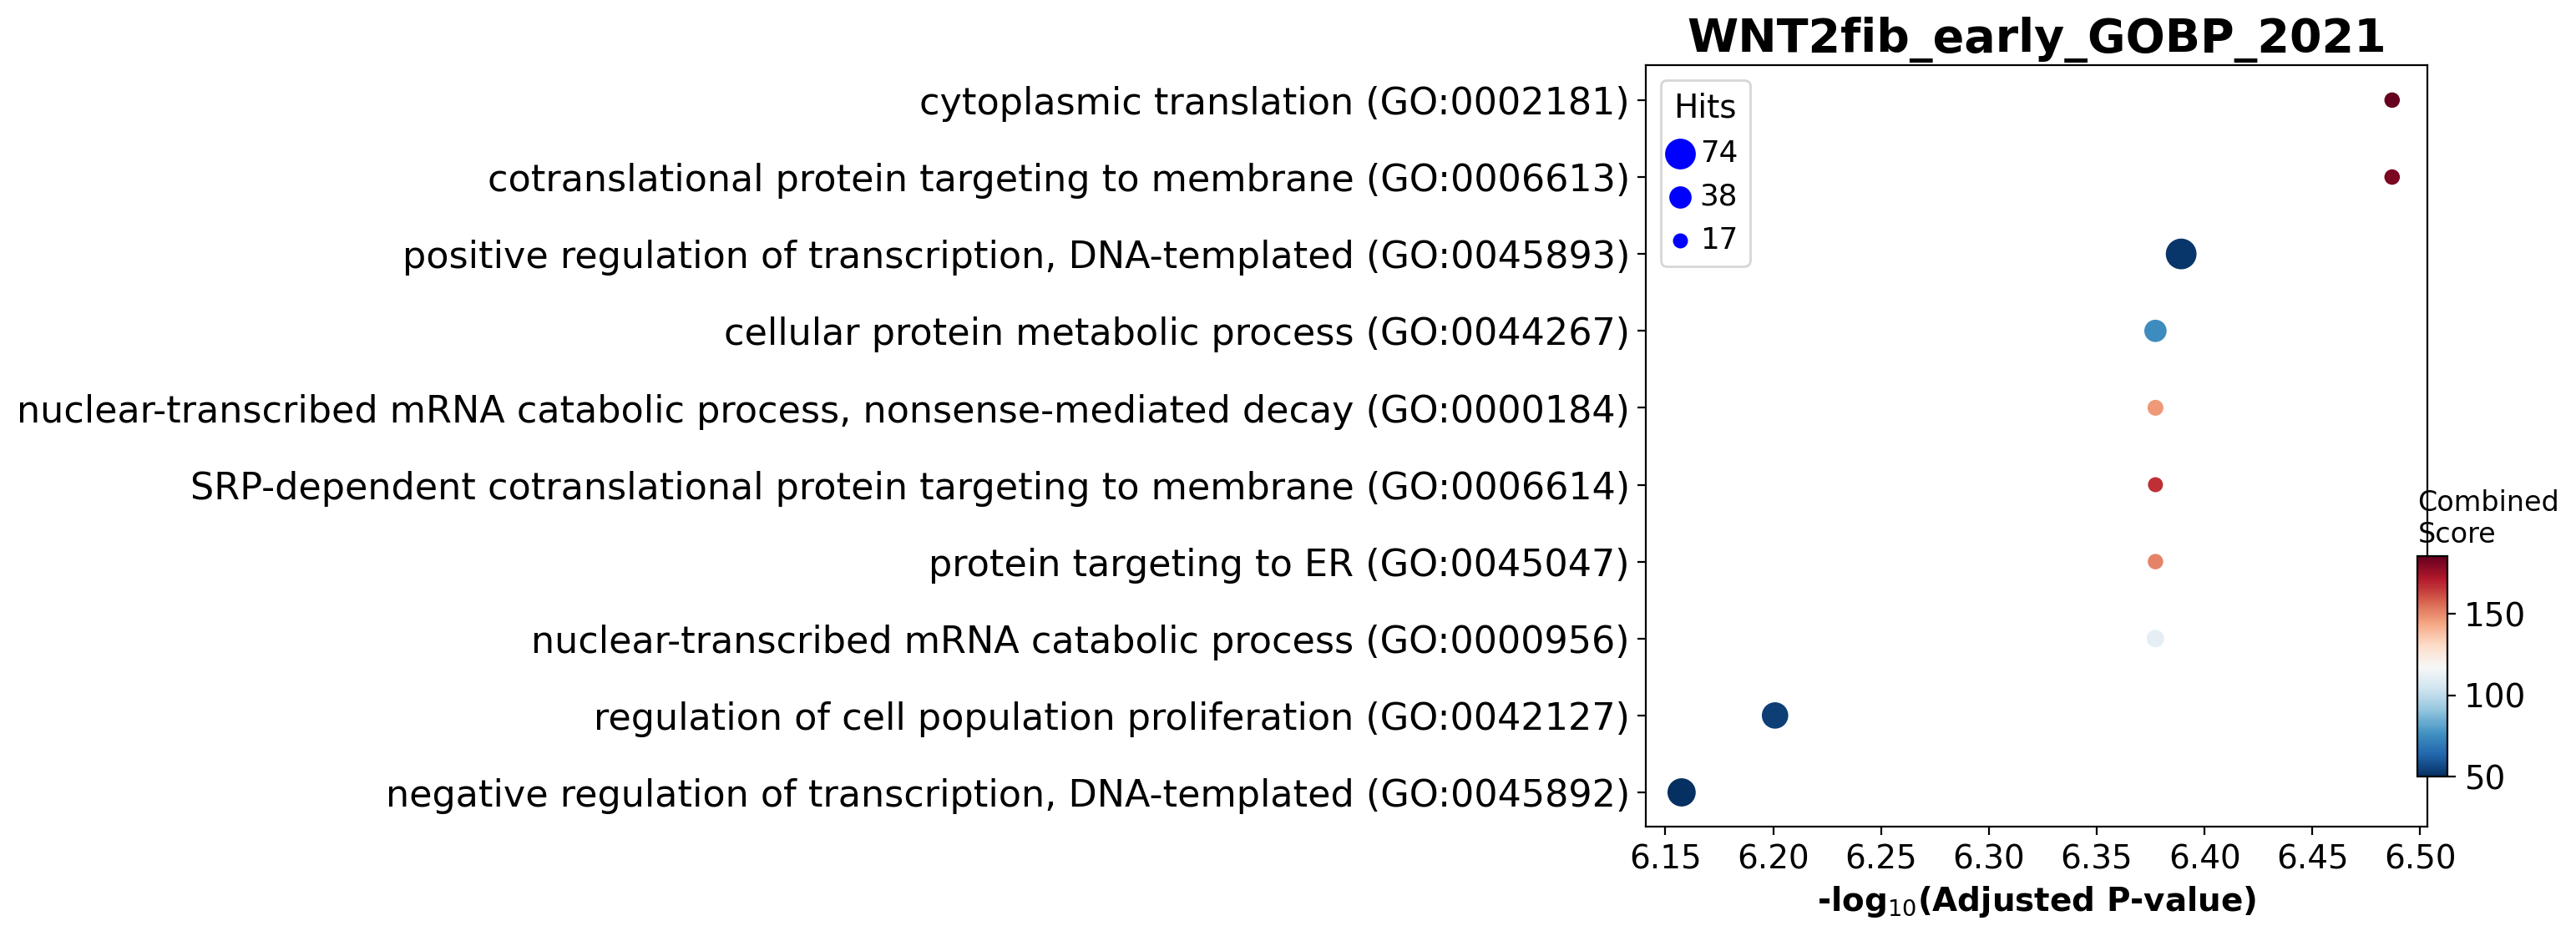

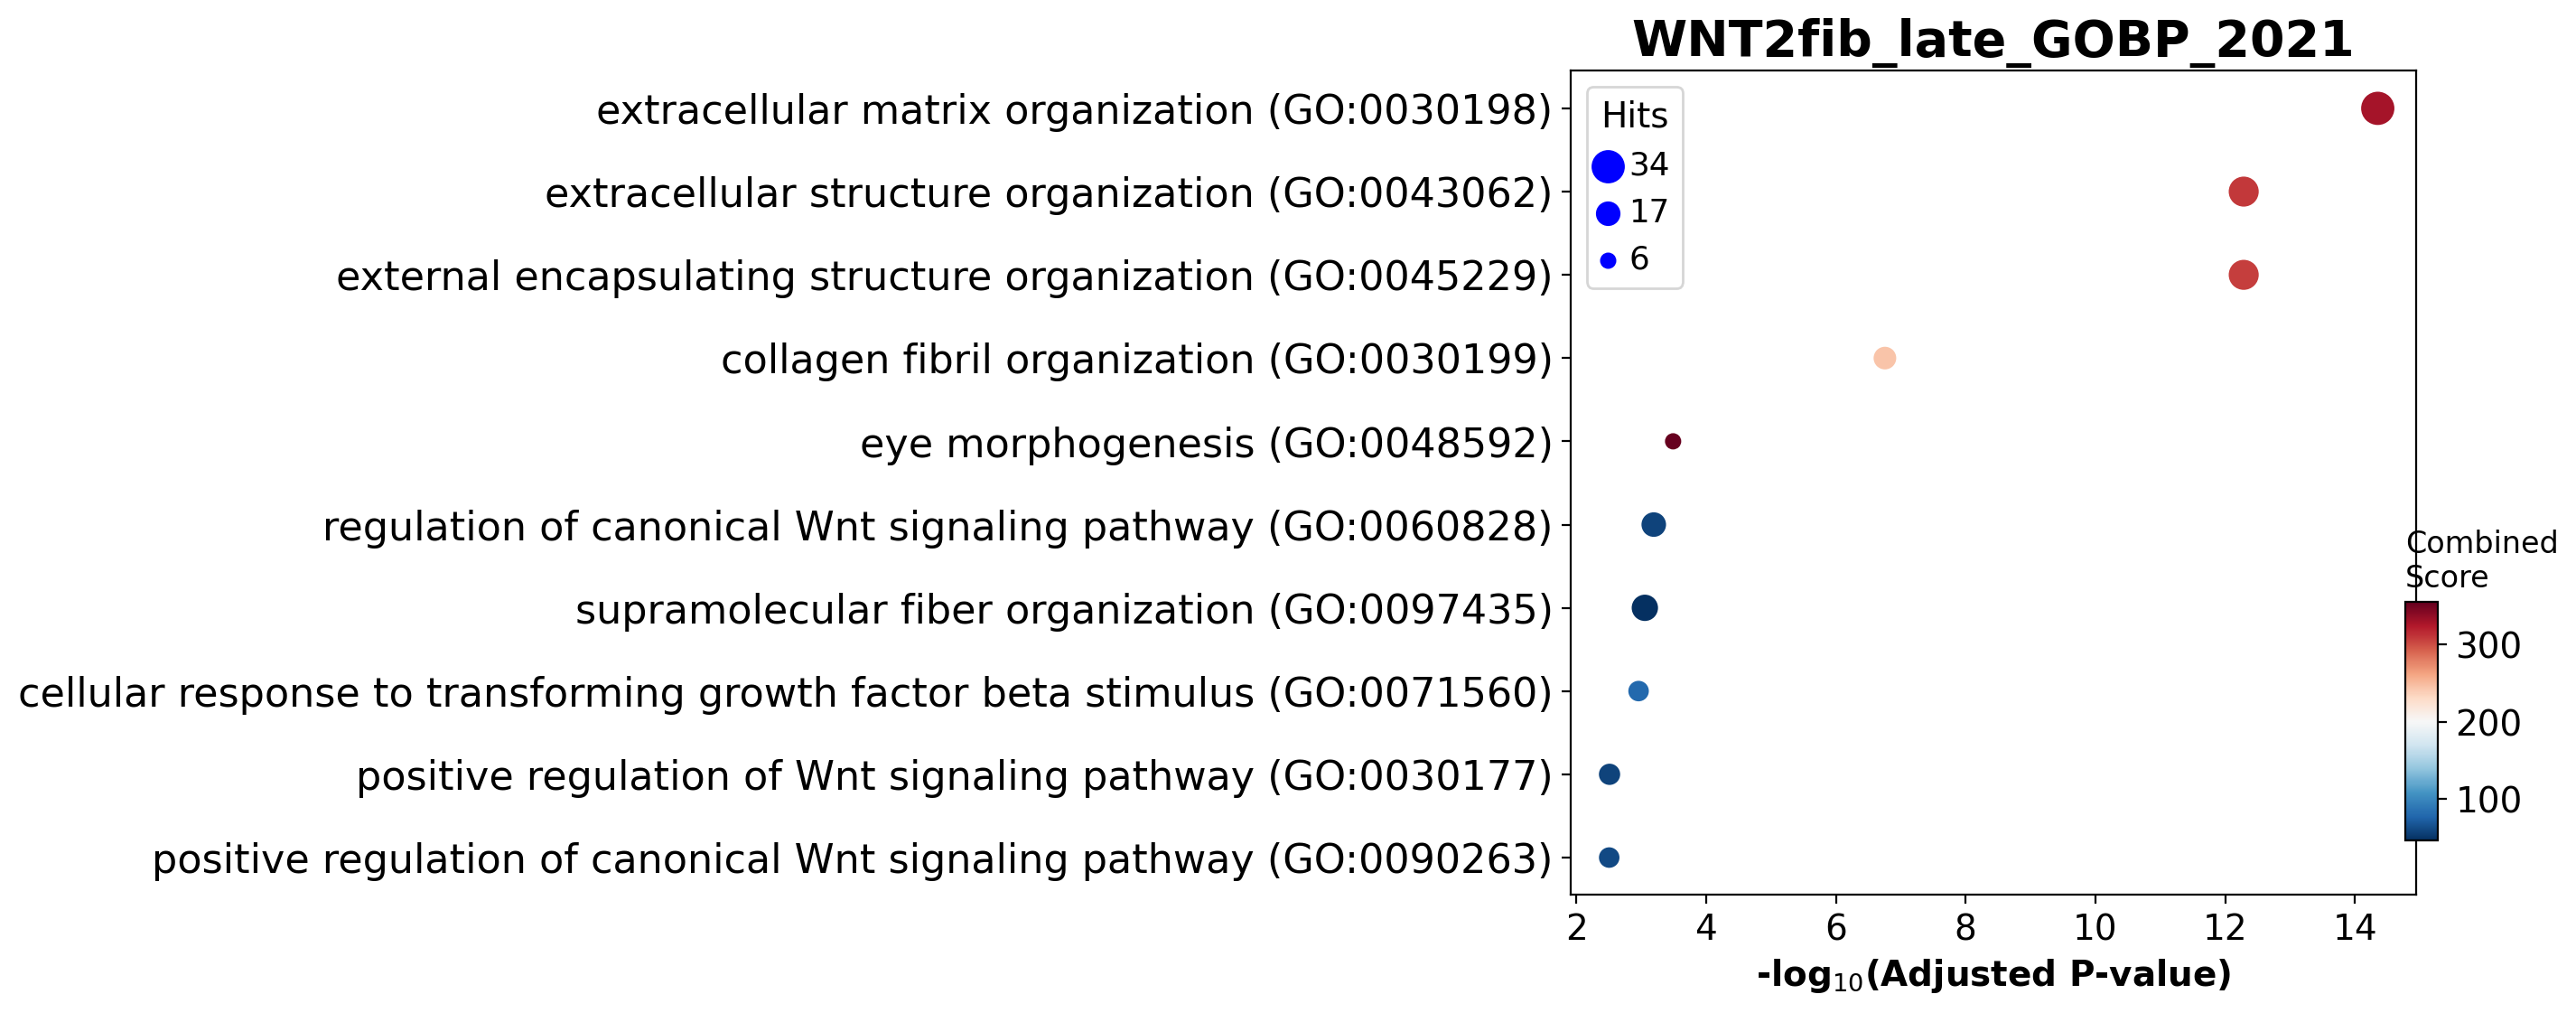

In [45]:
gp.dotplot(enr_WNT2fibearly.res2d,title='WNT2fib_early_GOBP_2021', top_term=10, figsize=(6,6))
gp.dotplot(enr_WNT2fiblate.res2d,title='WNT2fib_late_GOBP_2021',  top_term=10, figsize=(6,6))
#gp.dotplot(enr_WNT2fibearly.res2d,title='WNT2fib_early_GOBP_2021', top_term=10, figsize=(6,6), ofname='WNT2_early_GOBP_11062023.pdf')
##gp.dotplot(enr_WNT2fibearly_Hallmark.res2d,title='WNT2fib_early_MSigDB_Hallmark_2020',  top_term=10, cmap='viridis')
#gp.dotplot(enr_WNT2fiblate.res2d,title='WNT2fib_late_GOBP_2021',  top_term=10, figsize=(6,6), ofname='WNT2_late_11062023.pdf')
##gp.dotplot(enr_WNT2fiblate_Hallmark.res2d,title='WNT2fib_late_MSigDB_Hallmark_2020',  top_term=10, cmap='viridis')

# Plot DEGs from early-late WNT2+ comparison by PCW

## Create object WNT2+ fibroblast only

In [46]:
#slice prenatal skin object to WNT2+ fibroblast only

WNT2_fib = ['WNT2+ fibroblast']
adata_WNT2 = adata[adata.obs['joint_annotation_20220202'].isin(WNT2_fib)]
adata_WNT2

View of AnnData object with n_obs × n_vars = 29109 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220

In [47]:
print(list(adata_WNT2.obs['pcw'].unique()))

[8, 9, 10, 7, 13, 16, 12, 15, 11, 14]


In [48]:
new_bins = {
'7' : '7-8',
'8' : '7-8',
'9' : '9-11',
'10' : '9-11',
'11' : '9-11',
'12' : '12-13',
'13' : '12-13',
'14' : '14-16',
'15' : '14-16',
'16' : '14-16'
}
new_bins

{'7': '7-8',
 '8': '7-8',
 '9': '9-11',
 '10': '9-11',
 '11': '9-11',
 '12': '12-13',
 '13': '12-13',
 '14': '14-16',
 '15': '14-16',
 '16': '14-16'}

In [49]:
adata_WNT2.obs['pcw_binned'] = adata_WNT2.obs['pcw'].astype(str).map(new_bins)
adata_WNT2.obs['pcw_binned'] = adata_WNT2.obs['pcw_binned'].astype('category')
adata_WNT2.obs['pcw_binned'].value_counts()

Trying to set attribute `.obs` of view, copying.


14-16    13369
9-11      6844
7-8       6067
12-13     2829
Name: pcw_binned, dtype: int64

In [50]:
adata_WNT2.obs['pcw_binned'] = adata_WNT2.obs['pcw_binned'].cat.reorder_categories([
'7-8',
'9-11',
'12-13',
'14-16'
])

In [51]:
print(list(adata_WNT2.obs['joint_annotation_20220202'].unique()))

['WNT2+ fibroblast']


## Plot matrix plot

In [52]:
#Based on DEGs and GSEApy analyses above - list of genes and corresponding functions selected

In [53]:
#Create dictionary
markers_WNT2_earlylate = {
 'Regulation of transciption' : ['EGR1', 'IGF1', 'IRF1', 'RDX', 'RPL23', 'TWIST1'],
 'Regulation of cell proliferation' : ['MDK', 'SFRP1', 'SFRP4', 'SOX11'],
 'Extracellular matrix organisation and collagen deposition' : ['ADAMTS5', 'ADAMTSL4', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A1', 'COL6A3', 'COL12A1', 'COL14A1', 'COL16A1',
                                                                'MFAP2', 'MFAP5', 'MMP14', 'POSTN', 'SPARC']}

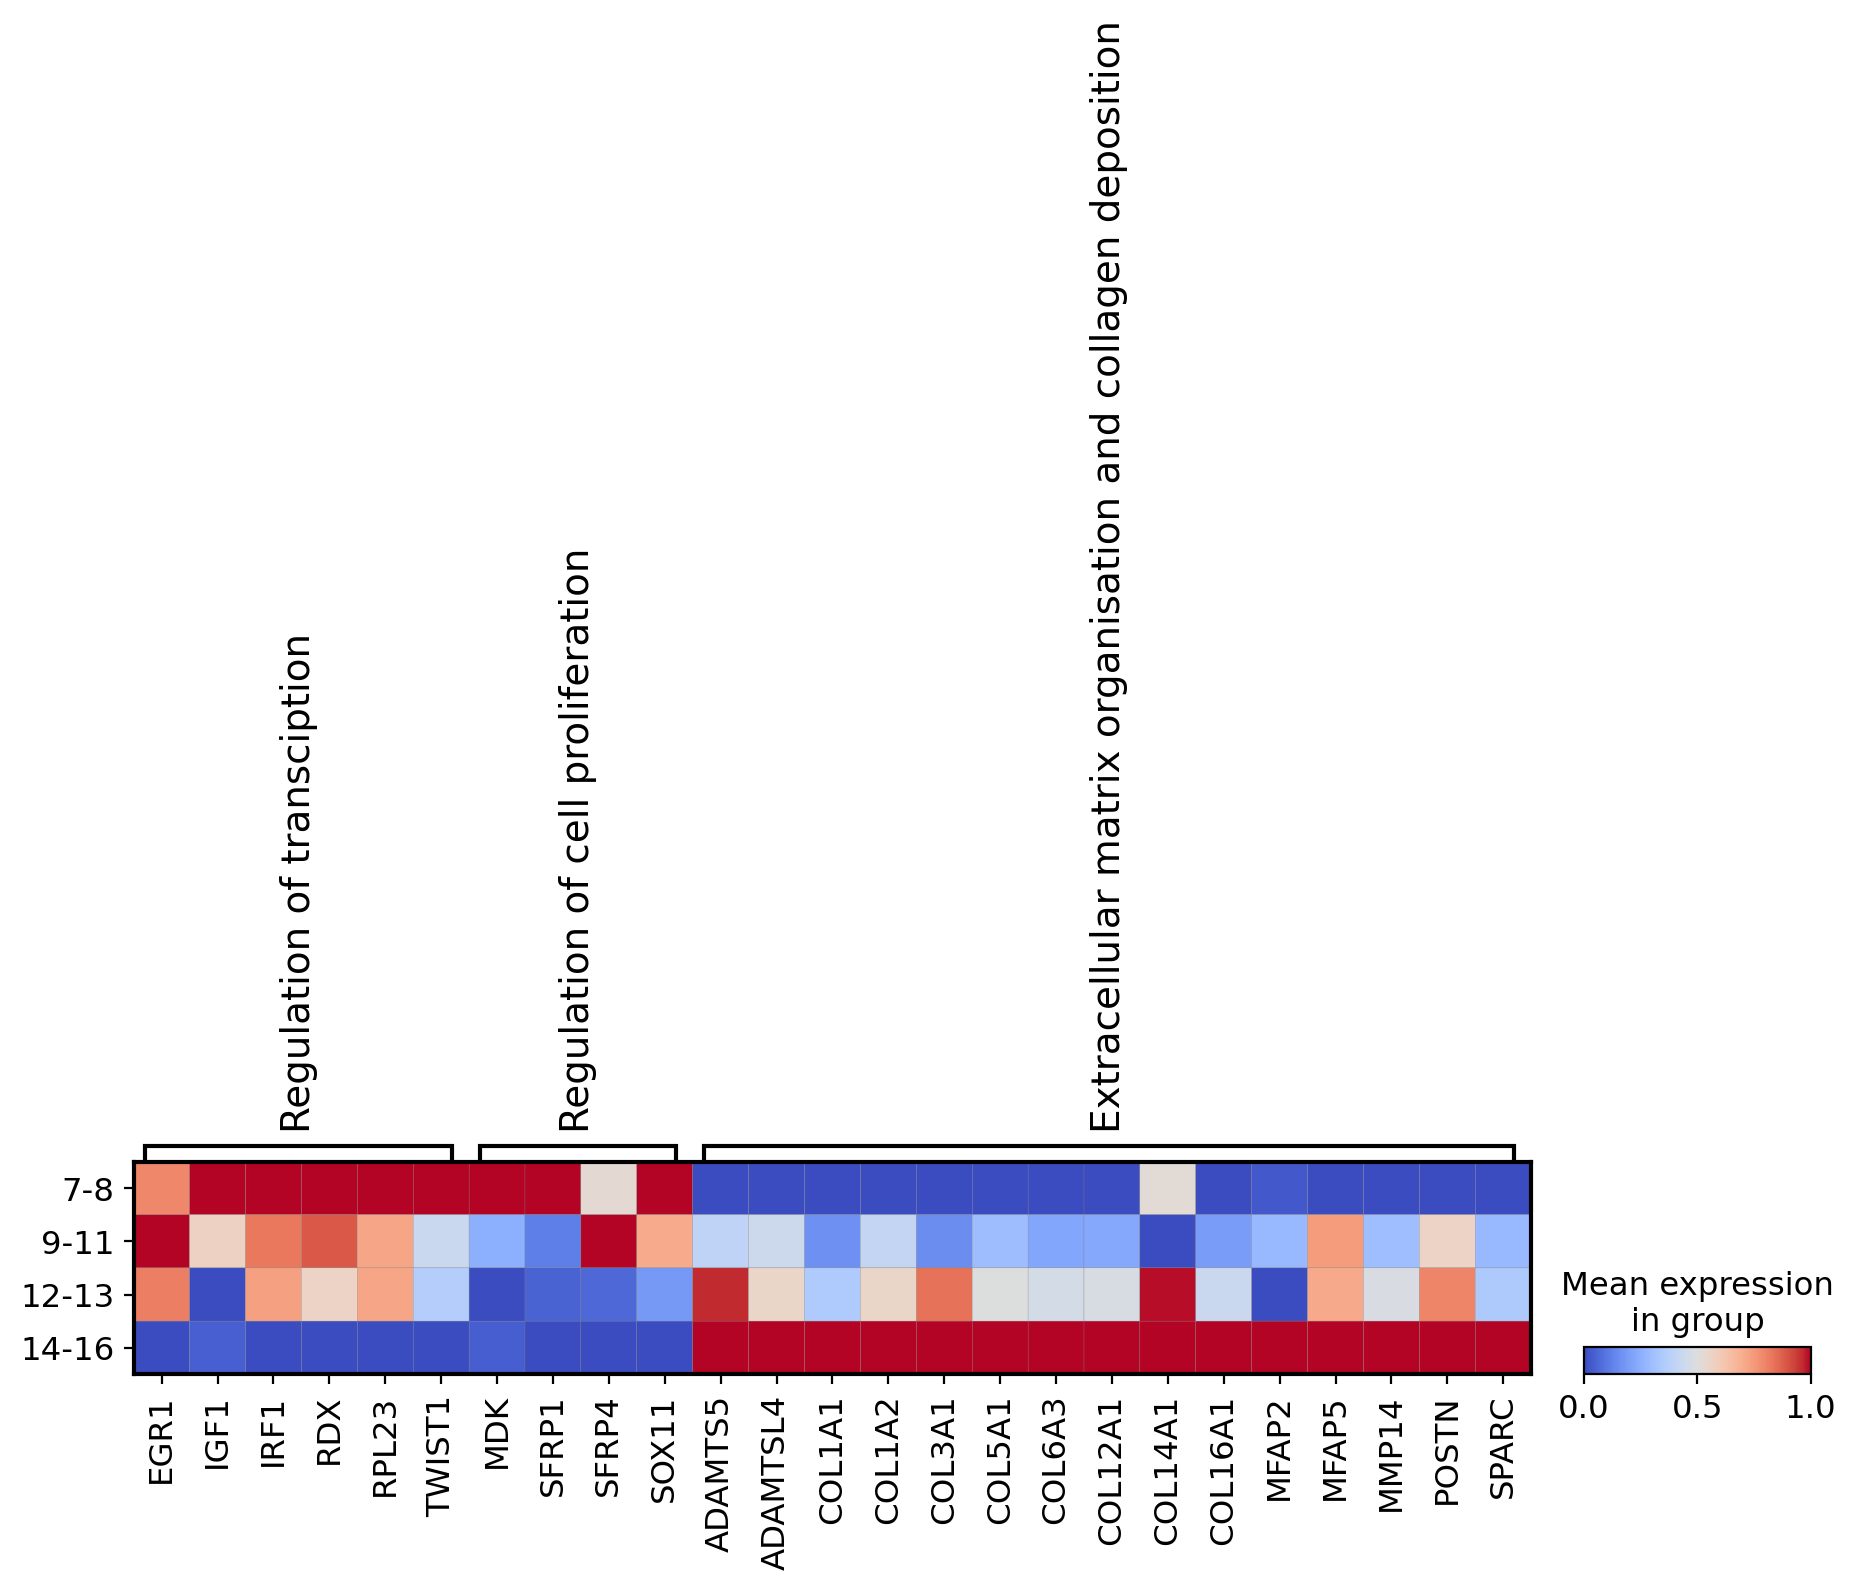

In [57]:
sc.pl.matrixplot(adata_WNT2, var_names=markers_WNT2_earlylate, groupby='pcw_binned', standard_scale='var', 
                 cmap='coolwarm')

#sc.pl.matrixplot(adata_WNT2, var_names=markers_WNT2_earlylate, groupby='pcw_binned', standard_scale='var', 
#                 cmap='coolwarm', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/figures_28042023/WNT2_comparison_groups_11062023.pdf')

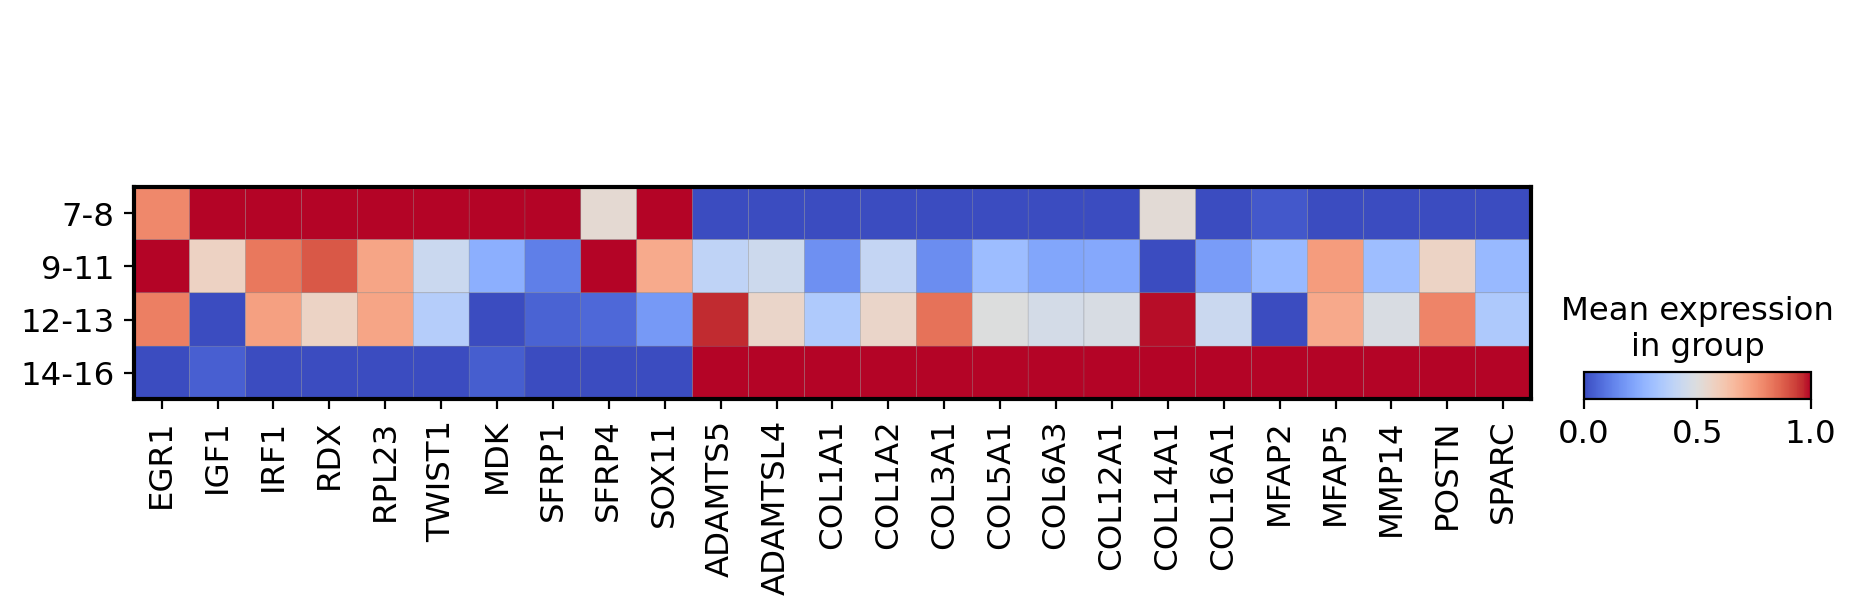

In [60]:
#plot same genes without functional annotations

sc.pl.matrixplot(adata_WNT2, var_names=['EGR1', 'IGF1', 'IRF1', 'RDX', 'RPL23', 'TWIST1', 'MDK', 'SFRP1', 'SFRP4', 'SOX11', 
                           'ADAMTS5', 'ADAMTSL4', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A1', 'COL6A3', 'COL12A1', 'COL14A1', 'COL16A1',
                                        'MFAP2', 'MFAP5', 'MMP14', 'POSTN', 'SPARC'], groupby='pcw_binned', 
                 standard_scale='var', cmap='coolwarm')

#sc.pl.matrixplot(adata_WNT2, var_names=['EGR1', 'IGF1', 'IRF1', 'RDX', 'RPL23', 'TWIST1', 'MDK', 'SFRP1', 'SFRP4', 'SOX11', 
#                           'ADAMTS5', 'ADAMTSL4', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A1', 'COL6A3', 'COL12A1', 'COL14A1', 'COL16A1',
#                                        'MFAP2', 'MFAP5', 'MMP14', 'POSTN', 'SPARC'], groupby='pcw_binned', 
#                 standard_scale='var', cmap='coolwarm', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/figures_28042023/WNT2_comparison_nogroups_11062023.pdf')